- 基于30w条维基百科中文数据训练得到word2vec模型 用于计算词语相似度
- 基于lac分词模型给出3.3w名用户的分词与词性标注结果
- 最终给出每个用户的兴趣的概率预测值

用户规模3.3w/5.7w

In [1]:
import numpy as np
import pandas as pd
import time
import gensim
from gensim.models import Word2Vec
from tqdm import tqdm

D:\software\anaconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


- 导入用户兴趣相关词库

In [2]:
df_game = pd.read_csv(r'D:\datasets\qianyi\user_label\game_similar.csv')   #与游戏相关的词库，评分是该单词与游戏的相似度
df_game

,game_similar_word,score
0,游戏,1.000000
1,玩家,0.849507
2,小游戏,0.820626
3,街机,0.813331
4,玩法,0.805901
...,...,...
72,强者,0.412994
73,域名,0.412396
74,修真,0.406966
75,绝招,0.406827


In [3]:
# df_game = df_game.append({'game_similar_word':'游戏','score':wiki30_model.wv.similarity('游戏','游戏')},ignore_index=True)
# df_game

In [4]:
df_game.sort_values(by='score',inplace=True,ascending=False)
df_game = df_game.reset_index(drop=True)                        #按照相似度对游戏进行降序排列
df_game

,game_similar_word,score
0,游戏,1.000000
1,玩家,0.849507
2,小游戏,0.820626
3,街机,0.813331
4,玩法,0.805901
...,...,...
72,强者,0.412994
73,域名,0.412396
74,修真,0.406966
75,绝招,0.406827


In [5]:
df_game.to_csv('game_similar.csv',index=False)

In [6]:
df_tweet = pd.read_csv(r'D:\datasets\data_test\3.3w用户分词1k内非空.csv')  #分词结果由lac模型得到    
'''
该表格文件包含了发帖用户的帖子的分词结果以及词性筛选的结果
'''
df_tweet

,Unnamed: 0,user_id,content,content_length,content_seq,content_select
0,0,1634847757,觉醒年代yyds！！！！！！ 觉醒年代葛树贵真实的结局觉醒年代 让很多人知道了一个从没听...,999,"[' ', '觉醒', '觉醒', '葛树贵', '真实', '结局', '觉醒', '很...","[' ', '葛树贵', '结局', '很多人', '葛树贵', '长辛店', '京郊',..."
1,1,6121645465,哈哈哈手机立刻把音量调小 妆效好美啊 太可爱了吧 猪姐太美了 看饿了 忍不住！ 疯狂...,999,"['手机', '音量', '妆效', '好美', '猪姐', ' ', ' ', '...","['手机', '音量', '妆效', '猪姐', ' ', ' ', ' ', '..."
2,2,5982298619,少年终会变成光，飞往星辰大海 我也要加油～ 铭记！铭记历史！永怀先烈，吾辈自强！ 我酸了 真...,999,"['飞往', '星辰', '大海', '加油', '铭记', '铭记', '历史', '先烈...","['星辰', '大海', '历史', '先烈', '吾辈', '犯规', ' 共产党', ..."
3,3,2688638604,沾 中国共产党100年 因为做了吃力不讨好的事情觉得好难过睡不着眼泪都掉下来 然后忘记撕的双...,999,"['中国共产党', '100年', '吃力不讨好', '好难过', '眼泪', '掉下来',...","['中国共产党', '眼泪', '双眼皮贴', '学姐', '毕业典礼', '舍友', '舍..."
4,4,7267921831,2021年第26周 早:红豆薏米糊+失败的厚蛋烧（但味道能吃） 中:爆炒非常+红苋菜+酱鸭 ...,999,"['2021年', '第26周', '红豆', '薏米糊+', '失败', '味道', '爆...","['红豆', '薏米糊+', '味道', '红豆', '薏米', '糊口感', '菜单', ..."
...,...,...,...,...,...,...
33785,33785,1860299730,qq,5,"[' ', 'qq']","[' ', 'qq']"
33786,33786,5608873136,透风,5,"['透风', ' ']","['透风', ' ']"
33787,33787,7592945242,橘子工厂,5,"['橘子', '工厂']","['橘子', '工厂']"
33788,33788,3805494971,玻璃肠胃,5,"['玻璃', '肠胃']","['玻璃', '肠胃']"


- 导入训练得到的word2vec模型（基于30w条中文语料库）

In [7]:
inp = r'D:\datasets\qianyi\user_label\model\wikich\wikich30w.model'       

In [8]:
wiki30_model = gensim.models.Word2Vec.load(inp)                  #加载通过中文维基百科数据集训练得到的word2vec模型

In [9]:
wiki30_model.wv.similar_by_word('旅游',topn=10)                  #检验模型的运行效果

[('travel', 0.7928603887557983),
 ('旅行团', 0.7741164565086365),
 ('bhogle', 0.7676228284835815),
 ('自驾游', 0.7594654560089111),
 ('不思溢', 0.7434412837028503),
 ('刘幸钰', 0.7415870428085327),
 ('自助游', 0.7403112649917603),
 ('香港游', 0.7395221590995789),
 ('导游', 0.7391347289085388),
 ('吊靴', 0.7387250065803528)]

In [10]:
len(wiki30_model.wv.index_to_key)                                #训练得到Word2vec模型的词向量的个数

1145213

In [11]:
wiki30_model.wv.similarity('游戏','游戏')             #检验两个词语的相似度

0.99999994

In [12]:
wiki30_model.wv.similarity('游戏','网游')

0.6040925

In [13]:
wiki30_model.wv.similarity('游戏','刀塔')

0.64694154

In [14]:
wiki30_model.wv.similarity('旅游','游戏')

0.36551937

## 用户对游戏兴趣值的填充 

### 计算第一个用户与'游戏'的相关度

In [15]:
start_time = time.time()

a = 0
interest_score = []
interest_related = 0
for i in range(len(eval(df_tweet['content_select'][a]))):          
    try:
        b = wiki30_model.wv.similarity('游戏',eval(df_tweet['content_select'][a])[i])
        interest_score.append(b) 
        i += 1
        interest_related += 1
    except KeyError:                                 #异常排除，处理分词结果不在word2vec模型中的情况
        interest_score.append(0)
print(interest_score)
print(interest_related)
if interest_related==0:
    print(0)
else:
    print(np.sum(interest_score)/interest_related)    #返回该拥护帖子所有分词结果与指定游戏词库词语之间相似度的平均值
    
end_time = time.time()
print(end_time-start_time)

[0, 0.413764, 0.62061274, 0, 0.413764, 0.26177925, 0.22974147, 0.50841236, 0.4447105, 0.413764, 0, 0.65017486, 0.3409029, 0.36179516, 0.53946805, 0, 0.28277388, 0, 0.423218, 0.23923951, 0.23923951, 0.36339077, 0.413764, 0.62061274, 0, 0.413764, 0.26177925, 0.22974147, 0.50841236, 0.4447105, 0.413764, 0, 0.65017486, 0.3409029, 0.36179516, 0.53946805, 0, 0.3728673, 0, 0.251904, 0, 0, 0, 0.44344985, 0.23083133, 0.26461813, 0.3492052, 0.44344985, 0, 0, 0.35675427, 0.53295934, 0.32416043, 0.32013863, 0.21019952, 0.51905656, 0.32013863, 0.21019952, 0.37292486, 0, 0.17181809, 0.32013863, 0.21019952, 0.37292486, 0.5340041, 0, 0.35910168, 0.3577612, 0.3577612, 0.3121087, 0.36180675, 0.27638018, 0, 0.3577612, 0.28997612, 0.36554605, 0.31375492, 0.30906555, 0.35910168, 0.30906555, 0.3577612, 0.36180675, 0.2857421, 0.19953844, 0.21663427, 0.26751655, 0.5203234, 0, 0.25010204, 0.37125742, 0.29114524, 0.34888473, 0, 0.42540175, 0.25819698, 0.29114524, 0.15878215, 0.36922193, 0.15878215, 0.2032544, 0

### 计算第一个用户对‘游戏’的兴趣值 

In [16]:
def interest_game_one(x,y=0):              #x为第x+1个user,y为词库的第y+1个单词
    interest_score = []
    interest_related = 0
    for i in range(len(eval(df_tweet['content_select'][x]))):
        try:
            a = wiki30_model.wv.similarity(eval(df_tweet['content_select'][x])[i],
                                           df_game['game_similar_word'][y])
            interest_score.append(a)
            i += 1
            interest_related += 1
        except KeyError:
            interest_score.append(0)
    if interest_related == 0:
        return 0
    else:
        return np.sum(interest_score)/interest_related  
    
# def interest_game_stock(x):
#     game_similar_score = []
#     num = 0
#     for i in range(len(df_game['game_similar_word'])):
#         game_score = interest_game_one(x,i)
#         game_similar_score.append(game_score)
#         if game_score != 0:
#             num+=1   
#     return np.sum(game_similar_score)/num
#     return np.sum(game_similar_score)/num,game_similar_score,num
#     print(game_similar_score)
#     print(num)
#     print(np.sum(game_similar_score)/num)
   

In [17]:
interest_game_one(0)             #第一个用户帖子分词结果与'游戏'的相似度

0.3601824895155673

In [18]:
def interest_game_stock(x):
    interest_score = []
    num = 0
    for i in range(len(eval(df_tweet['content_select'][x]))):
        for j in range(len(df_game['game_similar_word'])):
            try:
                a = wiki30_model.wv.similarity(eval(df_tweet['content_select'][x])[i],
                                           df_game['game_similar_word'][j])
                interest_score.append(a)
                j += 1
                num += 1
            except KeyError:
                interest_score.append(0)
        i += 1
    if num == 0:
        return 0
    else:
        return np.sum(interest_score)/num
#         return np.sum(interest_score)/num,interest_score,num


In [36]:
interest_game_stock(0)             #第一个用户帖子分词结果与游戏词库的相似度

0.31103947166607215

In [19]:
start_time = time.time()
print(interest_game_stock(0))
end_time = time.time()
print(end_time-start_time) 

0.31103947166607215
1.555513620376587


In [20]:
interest_game_one(3,2)             #第4个用户的帖子分词结果与词库第三个词语的相似度

0.3558867376739696

In [21]:
interest_game_stock(4)

0.32799788599277474

In [22]:
start_time = time.time()
print(interest_game_stock(90))
end_time = time.time()
print(end_time-start_time)

0.3222143245326889
0.9771006107330322


In [23]:
start_time = time.time()
print(interest_game_stock(1236))
end_time = time.time()
print(end_time-start_time)

0.3255904887651038
0.4786052703857422


In [24]:
start_time = time.time()
print(interest_game_stock(384))
end_time = time.time()
print(end_time-start_time)

0.32519917286102673
0.727733850479126


In [25]:
len(eval(df_tweet['content_select'][1236]))         #第1237个用户的分词数目

58

In [37]:
len(df_tweet)                                       #用户总数目

33790

In [40]:
from tqdm import tqdm
import time
start_time = time.time()

game_interest_value = []

for i in tqdm(range(len(df_tweet)),desc='demo: '):
    game_interest_value.append(interest_game_stock(i))
print(game_interest_value)                          #由上述函数给出用户对游戏的兴趣度预测值

end_time = time.time()
print(end_time-start_time)
# df_tweet['game_interest_value'] = pd.Series([interest_game_stock(i)\
#                                             for i in tqdm(range(len(df_tweet)),desc='demo: ')])
# print(df_tweet['game_interest_value'])


demo:   0%|▏                                                                      | 66/33790 [00:47<9:54:23,  1.06s/it]


demo:   0%|▎                                                                     | 132/33790 [01:30<5:45:57,  1.62it/s]


demo:   1%|▍                                                                     | 198/33790 [02:09<4:31:10,  2.06it/s]


demo:   1%|▌                                                                    | 265/33790 [02:55<11:48:25,  1.27s/it]


demo:   1%|▋                                                                    | 332/33790 [03:44<10:56:18,  1.18s/it]


demo:   1%|▊                                                                     | 399/33790 [04:24<5:39:51,  1.64it/s]


demo:   1%|▉                                                                     | 465/33790 [05:05<4:47:54,  1.93it/s]


demo:   2%|█                                                                     | 531/33790 [05:43<4:16:04,  2.16it/s]


demo:   2%|█▏                                                                    | 599/33790 [06:30<6:20:38,  1.45it/s]


demo:   2%|█▍                                                                    | 665/33790 [07:05<3:23:45,  2.71it/s]


demo:   2%|█▌                                                                    | 732/33790 [07:47<5:09:43,  1.78it/s]


demo:   2%|█▋                                                                    | 798/33790 [08:29<8:10:22,  1.12it/s]


demo:   3%|█▊                                                                    | 865/33790 [09:04<4:41:19,  1.95it/s]


demo:   3%|█▉                                                                    | 932/33790 [09:41<3:39:12,  2.50it/s]


demo:   3%|██                                                                   | 1000/33790 [10:15<5:08:11,  1.77it/s]


demo:   3%|██▏                                                                  | 1068/33790 [10:58<5:55:30,  1.53it/s]


demo:   3%|██▎                                                                  | 1134/33790 [11:39<5:43:32,  1.58it/s]


demo:   4%|██▍                                                                  | 1203/33790 [12:12<4:25:32,  2.05it/s]


demo:   4%|██▌                                                                  | 1271/33790 [12:46<3:05:51,  2.92it/s]


demo:   4%|██▋                                                                  | 1338/33790 [13:23<4:46:05,  1.89it/s]


demo:   4%|██▊                                                                  | 1405/33790 [14:00<3:53:33,  2.31it/s]


demo:   4%|███                                                                  | 1473/33790 [14:36<6:20:46,  1.41it/s]


demo:   5%|███▏                                                                 | 1539/33790 [15:11<5:46:18,  1.55it/s]


demo:   5%|███▎                                                                 | 1609/33790 [15:45<5:59:40,  1.49it/s]


demo:   5%|███▍                                                                 | 1675/33790 [16:21<4:24:46,  2.02it/s]


demo:   5%|███▌                                                                 | 1742/33790 [16:55<3:45:39,  2.37it/s]


demo:   5%|███▌                                                               | 1810/33790 [21:44<239:34:59, 26.97s/it]


demo:   6%|███▊                                                                 | 1878/33790 [22:16<3:24:43,  2.60it/s]


demo:   6%|███▉                                                                 | 1945/33790 [22:55<4:42:03,  1.88it/s]


demo:   6%|████                                                                 | 2012/33790 [23:33<4:22:23,  2.02it/s]


demo:   6%|████▏                                                                | 2080/33790 [24:06<5:20:19,  1.65it/s]


demo:   6%|████▍                                                                | 2148/33790 [24:39<3:05:04,  2.85it/s]


demo:   7%|████▌                                                                | 2214/33790 [25:08<3:49:11,  2.30it/s]


demo:   7%|████▋                                                                | 2284/33790 [25:37<4:00:16,  2.19it/s]


demo:   7%|████▊                                                                | 2352/33790 [26:08<2:46:53,  3.14it/s]


demo:   7%|████▉                                                                | 2419/33790 [26:39<3:58:40,  2.19it/s]


demo:   7%|█████                                                                | 2485/33790 [27:03<2:33:47,  3.39it/s]


demo:   8%|█████▏                                                               | 2554/33790 [27:35<5:27:04,  1.59it/s]


demo:   8%|█████▎                                                               | 2622/33790 [28:02<3:11:35,  2.71it/s]


demo:   8%|█████▍                                                               | 2688/33790 [28:29<3:14:22,  2.67it/s]


demo:   8%|█████▋                                                               | 2757/33790 [28:57<2:54:35,  2.96it/s]


demo:   8%|█████▊                                                               | 2825/33790 [29:26<3:15:03,  2.65it/s]


demo:   9%|█████▉                                                               | 2893/33790 [29:52<3:52:22,  2.22it/s]


demo:   9%|██████                                                               | 2960/33790 [30:19<4:03:01,  2.11it/s]


demo:   9%|██████▏                                                              | 3027/33790 [30:47<3:18:03,  2.59it/s]


demo:   9%|██████▎                                                              | 3097/33790 [31:17<5:22:05,  1.59it/s]


demo:   9%|██████▍                                                              | 3165/33790 [31:42<3:35:22,  2.37it/s]


demo:  10%|██████▌                                                              | 3233/33790 [32:14<4:02:38,  2.10it/s]


demo:  10%|██████▋                                                              | 3303/33790 [32:40<3:05:34,  2.74it/s]


demo:  10%|██████▉                                                              | 3371/33790 [33:04<2:28:22,  3.42it/s]


demo:  10%|███████                                                              | 3439/33790 [33:28<1:56:30,  4.34it/s]


demo:  10%|███████▏                                                             | 3509/33790 [33:49<2:25:38,  3.47it/s]


demo:  11%|███████▎                                                             | 3577/33790 [34:12<2:44:22,  3.06it/s]


demo:  11%|███████▍                                                             | 3646/33790 [34:35<2:26:49,  3.42it/s]


demo:  11%|███████▌                                                             | 3713/33790 [34:55<2:55:14,  2.86it/s]


demo:  11%|███████▋                                                             | 3780/33790 [35:21<2:44:14,  3.05it/s]


demo:  11%|███████▊                                                             | 3850/33790 [35:44<3:09:39,  2.63it/s]


demo:  12%|███████▉                                                             | 3916/33790 [36:05<2:23:43,  3.46it/s]


demo:  12%|████████▏                                                            | 3987/33790 [36:26<3:14:30,  2.55it/s]


demo:  12%|████████▎                                                            | 4053/33790 [36:48<2:40:53,  3.08it/s]


demo:   0%|▏                                                                 | 126/33790 [1:36:37<430:16:16, 46.01s/it]

demo:  12%|████████▍                                                            | 4120/33790 [37:41<2:22:28,  3.47it/s]


demo:  12%|████████▌                                                            | 4188/33790 [38:02<2:40:23,  3.08it/s]


demo:  13%|████████▋                                                            | 4258/33790 [38:24<2:11:28,  3.74it/s]


demo:  13%|████████▊                                                            | 4327/33790 [38:43<2:03:05,  3.99it/s]


demo:  13%|████████▉                                                            | 4399/33790 [39:03<2:01:23,  4.04it/s]


demo:  13%|█████████▏                                                           | 4470/33790 [39:21<2:22:39,  3.43it/s]


demo:  13%|█████████▎                                                           | 4539/33790 [39:41<1:53:03,  4.31it/s]


demo:  14%|█████████▍                                                           | 4609/33790 [40:01<1:47:37,  4.52it/s]


demo:  14%|█████████▌                                                           | 4680/33790 [40:20<2:04:36,  3.89it/s]


demo:  14%|█████████▋                                                           | 4752/33790 [40:41<3:25:01,  2.36it/s]


demo:  14%|█████████▊                                                           | 4819/33790 [41:02<2:24:43,  3.34it/s]


demo:  14%|█████████▉                                                           | 4888/33790 [41:21<2:05:47,  3.83it/s]


demo:  15%|██████████                                                           | 4957/33790 [41:43<2:11:19,  3.66it/s]


demo:  15%|██████████▎                                                          | 5027/33790 [42:01<1:52:34,  4.26it/s]


demo:  15%|██████████▍                                                          | 5097/33790 [42:23<2:48:09,  2.84it/s]


demo:  15%|██████████▌                                                          | 5167/33790 [42:41<1:50:44,  4.31it/s]


demo:  15%|██████████▋                                                          | 5236/33790 [43:01<2:26:10,  3.26it/s]


demo:  16%|██████████▊                                                          | 5306/33790 [43:18<2:03:20,  3.85it/s]


demo:  16%|██████████▉                                                          | 5380/33790 [43:35<1:35:30,  4.96it/s]


demo:  16%|███████████▏                                                         | 5454/33790 [43:52<2:26:40,  3.22it/s]


demo:  16%|███████████▎                                                         | 5527/33790 [44:10<1:34:39,  4.98it/s]


demo:  17%|███████████▍                                                         | 5598/33790 [44:28<1:34:19,  4.98it/s]


demo:  17%|███████████▌                                                         | 5670/33790 [44:46<2:57:19,  2.64it/s]


demo:  17%|███████████▋                                                         | 5751/33790 [45:04<1:49:31,  4.27it/s]


demo:  17%|███████████▉                                                         | 5824/33790 [45:21<1:58:25,  3.94it/s]


demo:  17%|████████████                                                         | 5901/33790 [45:38<1:19:06,  5.88it/s]


demo:  18%|████████████▏                                                        | 5973/33790 [45:56<2:15:24,  3.42it/s]


demo:  18%|████████████▎                                                        | 6044/33790 [46:13<2:19:41,  3.31it/s]


demo:  18%|████████████▍                                                        | 6117/33790 [46:29<2:09:44,  3.55it/s]


demo:  18%|████████████▋                                                        | 6191/33790 [46:46<1:37:58,  4.69it/s]


demo:  19%|████████████▊                                                        | 6263/33790 [47:04<1:46:50,  4.29it/s]


demo:  19%|████████████▉                                                        | 6332/33790 [47:18<1:01:49,  7.40it/s]


demo:  19%|█████████████                                                        | 6401/33790 [47:35<2:26:55,  3.11it/s]


demo:  19%|█████████████▏                                                       | 6475/33790 [47:50<2:14:59,  3.37it/s]


demo:  19%|█████████████▎                                                       | 6548/33790 [48:05<2:12:51,  3.42it/s]


demo:  20%|█████████████▌                                                       | 6618/33790 [48:19<1:28:52,  5.10it/s]


demo:  20%|█████████████▋                                                       | 6694/33790 [48:35<1:48:36,  4.16it/s]


demo:  20%|█████████████▊                                                       | 6770/33790 [48:51<2:17:32,  3.27it/s]


demo:  20%|█████████████▉                                                       | 6844/33790 [49:06<1:50:34,  4.06it/s]


demo:  20%|██████████████▏                                                      | 6918/33790 [49:20<1:19:05,  5.66it/s]


demo:  21%|██████████████▎                                                      | 6999/33790 [49:35<1:25:46,  5.21it/s]


demo:  21%|██████████████▍                                                      | 7077/33790 [49:50<1:22:32,  5.39it/s]


demo:  21%|██████████████▌                                                      | 7153/33790 [50:04<1:03:47,  6.96it/s]


demo:  21%|██████████████▊                                                      | 7234/33790 [50:18<1:31:05,  4.86it/s]


demo:  22%|██████████████▉                                                      | 7311/33790 [50:33<1:09:23,  6.36it/s]


demo:  22%|███████████████                                                      | 7389/33790 [50:46<1:32:26,  4.76it/s]


demo:  22%|███████████████▏                                                     | 7467/33790 [51:00<1:02:38,  7.00it/s]


demo:  22%|███████████████▍                                                     | 7537/33790 [51:14<1:58:43,  3.69it/s]


demo:  23%|███████████████▌                                                     | 7617/33790 [51:27<1:26:41,  5.03it/s]


demo:  23%|███████████████▋                                                     | 7699/33790 [51:40<1:11:07,  6.11it/s]


demo:  23%|███████████████▉                                                     | 7779/33790 [51:56<1:25:47,  5.05it/s]


demo:  23%|████████████████                                                     | 7854/33790 [52:10<1:13:33,  5.88it/s]


demo:  23%|████████████████▋                                                      | 7930/33790 [52:22<54:53,  7.85it/s]


demo:  24%|████████████████▎                                                    | 8014/33790 [52:36<1:05:10,  6.59it/s]


demo:  24%|████████████████▌                                                    | 8095/33790 [52:51<1:24:41,  5.06it/s]


demo:  24%|████████████████▋                                                    | 8173/33790 [53:06<1:16:50,  5.56it/s]


demo:  24%|████████████████▊                                                    | 8251/33790 [53:20<1:12:10,  5.90it/s]


demo:  25%|█████████████████▌                                                     | 8335/33790 [53:33<57:15,  7.41it/s]


demo:  25%|█████████████████▏                                                   | 8422/33790 [53:47<1:12:24,  5.84it/s]


demo:  25%|█████████████████▎                                                   | 8506/33790 [54:00<1:05:35,  6.42it/s]


demo:  25%|██████████████████                                                     | 8585/33790 [54:12<59:46,  7.03it/s]


demo:  26%|█████████████████▋                                                   | 8667/33790 [54:24<1:13:51,  5.67it/s]


demo:  26%|██████████████████▍                                                    | 8745/33790 [54:37<56:58,  7.33it/s]


demo:  26%|██████████████████▌                                                    | 8828/33790 [54:50<45:36,  9.12it/s]


demo:  26%|██████████████████▋                                                    | 8915/33790 [55:03<59:17,  6.99it/s]


demo:  27%|██████████████████▉                                                    | 9001/33790 [55:15<42:22,  9.75it/s]


demo:  27%|███████████████████▏                                                   | 9107/33790 [55:29<49:27,  8.32it/s]


demo:  27%|██████████████████▊                                                  | 9198/33790 [55:42<1:01:24,  6.67it/s]


demo:  27%|██████████████████▉                                                  | 9287/33790 [55:54<1:06:45,  6.12it/s]


demo:  28%|███████████████████▋                                                   | 9391/33790 [56:06<33:47, 12.03it/s]


demo:  28%|███████████████████▉                                                   | 9493/33790 [56:19<51:27,  7.87it/s]


demo:  28%|████████████████████▏                                                  | 9582/33790 [56:31<39:58, 10.09it/s]


demo:  29%|███████████████████▊                                                 | 9678/33790 [56:44<1:10:28,  5.70it/s]


demo:  29%|████████████████████▌                                                  | 9783/33790 [56:57<49:41,  8.05it/s]


demo:  29%|████████████████████▊                                                  | 9884/33790 [57:09<51:32,  7.73it/s]


demo:  30%|████████████████████▋                                                 | 10001/33790 [57:22<40:08,  9.88it/s]


demo:  30%|████████████████████▎                                               | 10103/33790 [57:36<1:05:50,  6.00it/s]


demo:  30%|█████████████████████                                                 | 10192/33790 [57:48<40:13,  9.78it/s]


demo:  30%|█████████████████████▎                                                | 10290/33790 [58:01<53:42,  7.29it/s]


demo:  31%|█████████████████████▌                                                | 10394/33790 [58:13<41:33,  9.38it/s]


demo:  31%|█████████████████████▊                                                | 10506/33790 [58:25<38:40, 10.03it/s]


demo:  31%|█████████████████████▉                                                | 10608/33790 [58:37<47:55,  8.06it/s]


demo:  32%|██████████████████████▏                                               | 10713/33790 [58:50<49:29,  7.77it/s]


demo:  32%|██████████████████████▍                                               | 10820/33790 [59:02<34:24, 11.13it/s]


demo:  32%|██████████████████████▋                                               | 10925/33790 [59:15<52:32,  7.25it/s]


demo:  33%|██████████████████████▊                                               | 11037/33790 [59:27<34:51, 10.88it/s]


demo:  33%|███████████████████████                                               | 11155/33790 [59:40<37:38, 10.02it/s]


demo:  33%|███████████████████████▎                                              | 11255/33790 [59:53<47:26,  7.92it/s]


demo:  34%|██████████████████████▉                                             | 11380/33790 [1:00:06<36:58, 10.10it/s]


demo:  34%|███████████████████████▏                                            | 11498/33790 [1:00:18<54:17,  6.84it/s]


demo:  34%|███████████████████████▍                                            | 11623/33790 [1:00:31<38:38,  9.56it/s]


demo:  35%|███████████████████████▋                                            | 11755/33790 [1:00:44<37:01,  9.92it/s]


demo:  35%|███████████████████████▉                                            | 11890/33790 [1:00:56<28:19, 12.89it/s]


demo:  36%|████████████████████████▏                                           | 12024/33790 [1:01:08<39:31,  9.18it/s]


demo:  36%|████████████████████████▍                                           | 12161/33790 [1:01:21<41:38,  8.66it/s]


demo:  36%|████████████████████████▋                                           | 12297/33790 [1:01:33<24:42, 14.50it/s]


demo:  37%|█████████████████████████                                           | 12437/33790 [1:01:46<37:58,  9.37it/s]


demo:  37%|█████████████████████████▎                                          | 12582/33790 [1:01:58<30:33, 11.56it/s]


demo:  38%|█████████████████████████▌                                          | 12719/33790 [1:02:09<25:11, 13.94it/s]


demo:  38%|█████████████████████████▊                                          | 12856/33790 [1:02:21<26:57, 12.94it/s]


demo:  38%|██████████████████████████▏                                         | 12993/33790 [1:02:33<41:42,  8.31it/s]


demo:  39%|██████████████████████████▍                                         | 13135/33790 [1:02:45<27:35, 12.47it/s]


demo:  39%|██████████████████████████▋                                         | 13276/33790 [1:02:57<35:41,  9.58it/s]


demo:  40%|██████████████████████████▉                                         | 13411/33790 [1:03:10<30:10, 11.26it/s]


demo:  40%|███████████████████████████▎                                        | 13551/33790 [1:03:21<35:38,  9.46it/s]


demo:  41%|███████████████████████████▌                                        | 13691/33790 [1:03:33<27:41, 12.10it/s]


demo:  41%|███████████████████████████▊                                        | 13830/33790 [1:03:45<41:01,  8.11it/s]


demo:  41%|████████████████████████████                                        | 13956/33790 [1:03:56<33:58,  9.73it/s]


demo:  42%|████████████████████████████▎                                       | 14093/33790 [1:04:08<30:02, 10.93it/s]


demo:  42%|████████████████████████████▋                                       | 14237/33790 [1:04:19<29:51, 10.92it/s]


demo:  43%|████████████████████████████▉                                       | 14388/33790 [1:04:30<25:11, 12.84it/s]


demo:  43%|█████████████████████████████▏                                      | 14526/33790 [1:04:41<25:11, 12.75it/s]


demo:  43%|█████████████████████████████▌                                      | 14676/33790 [1:04:52<20:58, 15.19it/s]


demo:  44%|█████████████████████████████▊                                      | 14838/33790 [1:05:03<19:35, 16.12it/s]


demo:  44%|██████████████████████████████▏                                     | 14985/33790 [1:05:13<24:45, 12.66it/s]


demo:  45%|██████████████████████████████▍                                     | 15151/33790 [1:05:25<26:45, 11.61it/s]


demo:  45%|██████████████████████████████▊                                     | 15304/33790 [1:05:36<21:54, 14.07it/s]


demo:  46%|███████████████████████████████                                     | 15454/33790 [1:05:45<21:09, 14.44it/s]


demo:  46%|███████████████████████████████▍                                    | 15612/33790 [1:05:56<17:46, 17.04it/s]


demo:  47%|███████████████████████████████▊                                    | 15783/33790 [1:06:06<14:01, 21.41it/s]


demo:  47%|████████████████████████████████                                    | 15957/33790 [1:06:16<18:14, 16.29it/s]


demo:  48%|████████████████████████████████▍                                   | 16124/33790 [1:06:26<15:29, 19.00it/s]


demo:  48%|████████████████████████████████▊                                   | 16301/33790 [1:06:35<21:32, 13.53it/s]


demo:  49%|█████████████████████████████████▏                                  | 16491/33790 [1:06:45<18:08, 15.89it/s]


demo:  49%|█████████████████████████████████▌                                  | 16700/33790 [1:06:56<15:43, 18.11it/s]


demo:  50%|█████████████████████████████████▉                                  | 16885/33790 [1:07:06<15:23, 18.30it/s]


demo:  51%|██████████████████████████████████▍                                 | 17101/33790 [1:07:16<15:51, 17.54it/s]


demo:  51%|██████████████████████████████████▊                                 | 17302/33790 [1:07:26<15:06, 18.20it/s]


demo:  52%|███████████████████████████████████▏                                | 17505/33790 [1:07:36<14:46, 18.38it/s]


demo:  52%|███████████████████████████████████▌                                | 17696/33790 [1:07:47<12:47, 20.96it/s]


demo:  53%|████████████████████████████████████                                | 17922/33790 [1:07:56<09:46, 27.07it/s]


demo:  54%|████████████████████████████████████▌                               | 18143/33790 [1:08:06<09:30, 27.42it/s]


demo:  54%|████████████████████████████████████▉                               | 18361/33790 [1:08:15<13:23, 19.21it/s]


demo:  55%|█████████████████████████████████████▍                              | 18584/33790 [1:08:24<09:30, 26.66it/s]


demo:  56%|█████████████████████████████████████▊                              | 18808/33790 [1:08:33<09:03, 27.57it/s]


demo:  56%|██████████████████████████████████████▎                             | 19059/33790 [1:08:43<07:16, 33.74it/s]


demo:  57%|██████████████████████████████████████▊                             | 19315/33790 [1:08:52<10:04, 23.95it/s]


demo:  58%|███████████████████████████████████████▍                            | 19580/33790 [1:09:01<07:24, 32.00it/s]


demo:  59%|███████████████████████████████████████▉                            | 19840/33790 [1:09:10<06:25, 36.17it/s]


demo:  60%|████████████████████████████████████████▍                           | 20108/33790 [1:09:19<08:23, 27.17it/s]


demo:  60%|█████████████████████████████████████████                           | 20383/33790 [1:09:28<08:37, 25.93it/s]


demo:  61%|█████████████████████████████████████████▌                          | 20681/33790 [1:09:37<06:00, 36.39it/s]


demo:  62%|██████████████████████████████████████████▏                         | 20980/33790 [1:09:45<05:47, 36.86it/s]


demo:  63%|██████████████████████████████████████████▊                         | 21282/33790 [1:09:54<05:47, 36.00it/s]


demo:  64%|███████████████████████████████████████████▍                        | 21576/33790 [1:10:03<08:46, 23.19it/s]


demo:  65%|███████████████████████████████████████████▉                        | 21858/33790 [1:10:12<04:33, 43.56it/s]


demo:  66%|████████████████████████████████████████████▋                       | 22216/33790 [1:10:21<05:18, 36.37it/s]


demo:  67%|█████████████████████████████████████████████▍                      | 22567/33790 [1:10:29<04:23, 42.53it/s]


demo:  68%|██████████████████████████████████████████████                      | 22902/33790 [1:10:38<04:44, 38.29it/s]


demo:  69%|██████████████████████████████████████████████▉                     | 23314/33790 [1:10:46<03:57, 44.15it/s]


demo:  70%|███████████████████████████████████████████████▋                    | 23724/33790 [1:10:54<02:45, 60.78it/s]


demo:  72%|████████████████████████████████████████████████▋                   | 24168/33790 [1:11:02<03:55, 40.80it/s]


demo:  73%|█████████████████████████████████████████████████▍                  | 24565/33790 [1:11:11<03:11, 48.14it/s]


demo:  74%|██████████████████████████████████████████████████▎                 | 25025/33790 [1:11:19<02:14, 65.17it/s]


demo:  76%|███████████████████████████████████████████████████▍                | 25530/33790 [1:11:27<02:04, 66.08it/s]


demo:  77%|████████████████████████████████████████████████████▍               | 26081/33790 [1:11:34<01:53, 67.82it/s]


demo:  79%|█████████████████████████████████████████████████████▌              | 26629/33790 [1:11:42<01:38, 72.81it/s]


demo:  81%|██████████████████████████████████████████████████████▊             | 27212/33790 [1:11:50<01:40, 65.63it/s]


demo:  82%|███████████████████████████████████████████████████████▊            | 27709/33790 [1:11:58<01:52, 54.26it/s]


demo:  84%|█████████████████████████████████████████████████████████           | 28369/33790 [1:12:05<00:57, 93.85it/s]


demo:  86%|█████████████████████████████████████████████████████████▋         | 29105/33790 [1:12:13<00:40, 117.09it/s]


demo:  88%|███████████████████████████████████████████████████████████▏       | 29837/33790 [1:12:20<00:37, 106.28it/s]


demo:  91%|█████████████████████████████████████████████████████████████      | 30799/33790 [1:12:28<00:19, 151.75it/s]


demo:  94%|███████████████████████████████████████████████████████████████▎   | 31919/33790 [1:12:35<00:11, 158.61it/s]


demo:  99%|██████████████████████████████████████████████████████████████████ | 33326/33790 [1:12:42<00:02, 180.87it/s]


demo: 100%|████████████████████████████████████████████████████████████████████| 33790/33790 [1:12:44<00:00,  7.74it/s]

[0.31103947166607215, 0.31929420479644033, 0.2986068832600522, 0.32350345614222525, 0.32799788599277474, 0.33972482563933354, 0.3163446505235516, 0.33224859616435626, 0.3190164745961347, 0.3361119215844115, 0.3162998779523789, 0.31449648189749874, 0.3430502410923651, 0.29210057046699833, 0.30490062609188706, 0.2956273109130152, 0.31699799306013365, 0.3387092403926619, 0.31089166616066793, 0.3298153775901376, 0.3092622616350404, 0.3296152726106055, 0.3028117146912974, 0.3140466309289311, 0.3197616604099303, 0.3308860562384951, 0.3293011209746754, 0.3278959099861411, 0.3326092485639483, 0.31458257459032113, 0.33877437851413955, 0.3157648200143672, 0.308308166709857, 0.31814301869951495, 0.313113387478746, 0.31920635453299745, 0.3215994513227204, 0.31490174434540275, 0.3257380061107299, 0.3377824878206786, 0.31550226102885487, 0.3315139405859161, 0.298062593034161, 0.32663370983770024, 0.30145528246483433, 0.3122353014889648, 0.3275955276033595, 0.306513488857241, 0.35632586322987453, 0.3

In [41]:
df_tweet['score'] = pd.Series(game_interest_value)
df_tweet

,Unnamed: 0,user_id,content,content_length,content_seq,content_select,score
0,0,1634847757,觉醒年代yyds！！！！！！ 觉醒年代葛树贵真实的结局觉醒年代 让很多人知道了一个从没听...,999,"[' ', '觉醒', '觉醒', '葛树贵', '真实', '结局', '觉醒', '很...","[' ', '葛树贵', '结局', '很多人', '葛树贵', '长辛店', '京郊',...",0.311039
1,1,6121645465,哈哈哈手机立刻把音量调小 妆效好美啊 太可爱了吧 猪姐太美了 看饿了 忍不住！ 疯狂...,999,"['手机', '音量', '妆效', '好美', '猪姐', ' ', ' ', '...","['手机', '音量', '妆效', '猪姐', ' ', ' ', ' ', '...",0.319294
2,2,5982298619,少年终会变成光，飞往星辰大海 我也要加油～ 铭记！铭记历史！永怀先烈，吾辈自强！ 我酸了 真...,999,"['飞往', '星辰', '大海', '加油', '铭记', '铭记', '历史', '先烈...","['星辰', '大海', '历史', '先烈', '吾辈', '犯规', ' 共产党', ...",0.298607
3,3,2688638604,沾 中国共产党100年 因为做了吃力不讨好的事情觉得好难过睡不着眼泪都掉下来 然后忘记撕的双...,999,"['中国共产党', '100年', '吃力不讨好', '好难过', '眼泪', '掉下来',...","['中国共产党', '眼泪', '双眼皮贴', '学姐', '毕业典礼', '舍友', '舍...",0.323503
4,4,7267921831,2021年第26周 早:红豆薏米糊+失败的厚蛋烧（但味道能吃） 中:爆炒非常+红苋菜+酱鸭 ...,999,"['2021年', '第26周', '红豆', '薏米糊+', '失败', '味道', '爆...","['红豆', '薏米糊+', '味道', '红豆', '薏米', '糊口感', '菜单', ...",0.327998
...,...,...,...,...,...,...,...
33785,33785,1860299730,qq,5,"[' ', 'qq']","[' ', 'qq']",0.362307
33786,33786,5608873136,透风,5,"['透风', ' ']","['透风', ' ']",0.344299
33787,33787,7592945242,橘子工厂,5,"['橘子', '工厂']","['橘子', '工厂']",0.335953
33788,33788,3805494971,玻璃肠胃,5,"['玻璃', '肠胃']","['玻璃', '肠胃']",0.283171


In [43]:
df_tweet['score'].describe()

count    33790.000000
mean         0.315252
std          0.058648
min          0.000000
25%          0.307707
50%          0.321312
75%          0.337298
max          0.553486
Name: score, dtype: float64

In [46]:
score_max = np.max(df_tweet['score'])
score_min = np.min(df_tweet['score'])
score_mean = np.mean(df_tweet['score'])
score_std = np.std(df_tweet['score'])

In [45]:
score_max

0.5534858405590057

- 散点图

In [50]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'SimHei'

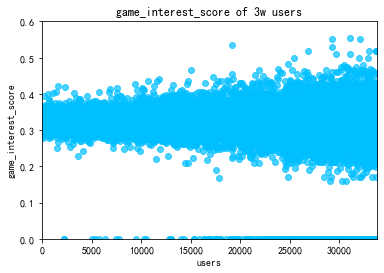

In [51]:
plt.xlim(0, len(df_tweet))
plt.ylim(0, 0.6)
plt.axis()
# 设置title和x，y轴的label
plt.title("game_interest_score of 3w users")
plt.xlabel("users")
plt.ylabel("game_interest_score")
plt.scatter(np.arange(len(df_tweet)), df_tweet['score'],color='deepskyblue',alpha=0.7)
plt.show()

## min-max标准化（Min-Max Normalization）

### 化为0-1上的小数

In [64]:
df_tweet['score_lin'] = df_tweet['score'].\
apply(lambda x: (x-score_min)/(score_max-score_min))

In [65]:
df_tweet['score_lin']

0        0.561965
1        0.576879
2        0.539502
3        0.584484
4        0.592604
           ...   
33785    0.654591
33786    0.622055
33787    0.606977
33788    0.511615
33789    0.461250
Name: score_lin, Length: 33790, dtype: float64

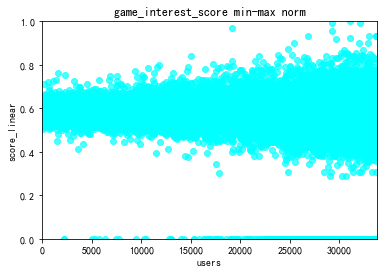

In [66]:
plt.xlim(0, len(df_tweet))
plt.ylim(0, 1)
plt.axis()
# 设置title和x，y轴的label
plt.title("game_interest_score min-max norm")
plt.xlabel("users")
plt.ylabel("score_linear")
plt.scatter(np.arange(len(df_tweet)), df_tweet['score_lin'],color='cyan',alpha=0.7)
plt.show()

## z-score标准化（Z-score standardization）

### 化为标准正太分布

In [57]:
df_tweet['score_std'] = df_tweet['score'].\
apply(lambda x: (x-score_mean)/score_std)
df_tweet['score_std']

0       -0.071827
1        0.068925
2       -0.283815
3        0.140697
4        0.217331
           ...   
33785    0.802336
33786    0.495279
33787    0.352975
33788   -0.547005
33789   -1.022325
Name: score_std, Length: 33790, dtype: float64

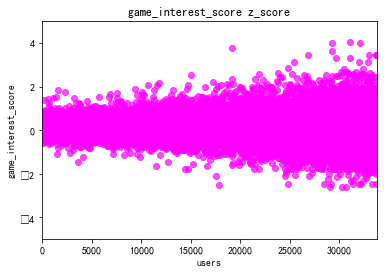

In [59]:
plt.xlim(0, len(df_tweet))
plt.ylim(-5, 5)
plt.axis()
# 设置title和x，y轴的label
plt.title("game_interest_score z_score")
plt.xlabel("users")
plt.ylabel("game_interest_score")
plt.scatter(np.arange(len(df_tweet)), df_tweet['score_std'],color='magenta',alpha=0.7)
plt.show()

## 验证

In [67]:
df_tweet

,Unnamed: 0,user_id,content,content_length,content_seq,content_select,score,score_lin,score_std
0,0,1634847757,觉醒年代yyds！！！！！！ 觉醒年代葛树贵真实的结局觉醒年代 让很多人知道了一个从没听...,999,"[' ', '觉醒', '觉醒', '葛树贵', '真实', '结局', '觉醒', '很...","[' ', '葛树贵', '结局', '很多人', '葛树贵', '长辛店', '京郊',...",0.311039,0.561965,-0.071827
1,1,6121645465,哈哈哈手机立刻把音量调小 妆效好美啊 太可爱了吧 猪姐太美了 看饿了 忍不住！ 疯狂...,999,"['手机', '音量', '妆效', '好美', '猪姐', ' ', ' ', '...","['手机', '音量', '妆效', '猪姐', ' ', ' ', ' ', '...",0.319294,0.576879,0.068925
2,2,5982298619,少年终会变成光，飞往星辰大海 我也要加油～ 铭记！铭记历史！永怀先烈，吾辈自强！ 我酸了 真...,999,"['飞往', '星辰', '大海', '加油', '铭记', '铭记', '历史', '先烈...","['星辰', '大海', '历史', '先烈', '吾辈', '犯规', ' 共产党', ...",0.298607,0.539502,-0.283815
3,3,2688638604,沾 中国共产党100年 因为做了吃力不讨好的事情觉得好难过睡不着眼泪都掉下来 然后忘记撕的双...,999,"['中国共产党', '100年', '吃力不讨好', '好难过', '眼泪', '掉下来',...","['中国共产党', '眼泪', '双眼皮贴', '学姐', '毕业典礼', '舍友', '舍...",0.323503,0.584484,0.140697
4,4,7267921831,2021年第26周 早:红豆薏米糊+失败的厚蛋烧（但味道能吃） 中:爆炒非常+红苋菜+酱鸭 ...,999,"['2021年', '第26周', '红豆', '薏米糊+', '失败', '味道', '爆...","['红豆', '薏米糊+', '味道', '红豆', '薏米', '糊口感', '菜单', ...",0.327998,0.592604,0.217331
...,...,...,...,...,...,...,...,...,...
33785,33785,1860299730,qq,5,"[' ', 'qq']","[' ', 'qq']",0.362307,0.654591,0.802336
33786,33786,5608873136,透风,5,"['透风', ' ']","['透风', ' ']",0.344299,0.622055,0.495279
33787,33787,7592945242,橘子工厂,5,"['橘子', '工厂']","['橘子', '工厂']",0.335953,0.606977,0.352975
33788,33788,3805494971,玻璃肠胃,5,"['玻璃', '肠胃']","['玻璃', '肠胃']",0.283171,0.511615,-0.547005


In [68]:
df_tweet.describe()

,Unnamed: 0,user_id,content_length,score,score_lin,score_std
count,33790.000000,3.379000e+04,33790.000000,33790.000000,33790.000000,3.379000e+04
mean,16894.500000,5.221382e+09,289.737763,0.315252,0.569575,-2.614631e-14
std,9754.477134,1.826283e+09,256.371244,0.058648,0.105962,1.000015e+00
min,0.000000,9.539308e+06,4.000000,0.000000,0.000000,-5.375364e+00
25%,8447.250000,3.631319e+09,83.000000,0.307707,0.555944,-1.286506e-01
50%,16894.500000,5.682321e+09,200.000000,0.321312,0.580524,1.033275e-01
75%,25341.750000,6.517056e+09,439.000000,0.337298,0.609408,3.759154e-01
max,33789.000000,7.646379e+09,999.000000,0.553486,1.000000,4.062128e+00


In [71]:
df_tweet.sort_values('score_lin',inplace=True,ascending=False)
df_tweet

,Unnamed: 0,user_id,content,content_length,content_seq,content_select,score,score_lin,score_std
31127,31127,5506154974,忙着打游戏撩小哥哥 不是到最后大家一起把浪漫杀死，谁也没觉得抱歉。,34,"['游戏', '小哥哥', '浪漫', '杀死', '抱歉']","['游戏', '小哥哥']",0.553486,1.000000,4.062128
32045,32045,5641500411,是个玩家 看不出已经32了吧 今天穿什么 在厦门,26,"['玩家', ' ']","['玩家', ' ']",0.550230,0.994117,4.006606
29302,29302,7194311249,摩尔庄园 勾八玩家汶怎么了 我就搞不懂了 而且改不了 到底啥时候能改啊 急急急 友友们怎么办啊,48,"['摩尔庄园', '玩家', '搞不懂', '急急急', '友友们']","['摩尔庄园', '玩家', '友友们']",0.550230,0.994117,4.006606
19128,19128,6066091469,巨好笑 冲 好温暖 陌生人守护的童心 苍天啊太有爱了吧 落泪了家人们 ...,160,"['好笑 冲 好温暖 ', '守护的童心 苍天啊太有爱了吧 ', '落泪...","['家人们', ' ', '幕星社']",0.535462,0.967435,3.754801
29270,29270,1900088170,日加满的直播简直太火爆了，快来看！ 0点抢爆款单品85折 http:t.cn/A6VCQ1v4,48,"['加满', '火爆', '0点', '爆款', '85折', 'cn/A6VCQ1v4']","['爆款', 'cn/A6VCQ1v4']",0.529693,0.957012,3.656432
...,...,...,...,...,...,...,...,...,...
25244,25244,5188532721,今天是我的生日07月09日，来祝福我吧~ 9命啊好配啊 iKON (아이콘)《GOODB...,83,"['我的生日', '07月09日', '啊 iKON (아이콘', 'GOODBYE RO...","['我的生日', 'GOODBYE ROAD', ' ']",0.000000,0.000000,-5.375364
26748,26748,5949849595,不好吃 有是累瘫了的一天 好吃的不得了 来一份江西...,69,"[' 不好吃 ', '累瘫', '一天 ', ' '...","[' ', ' ']",0.000000,0.000000,-5.375364
10480,10480,7429216155,junoflo junoflo junoflo junoflo coooooool ju...,364,['junoflo junoflo junoflo junoflo coooooool ...,['junoflo junoflo junoflo junoflo coooooool ...,0.000000,0.000000,-5.375364
33154,33154,5621488849,今天我升级为VIP7了,15,"['升级', 'VIP7', ' ']","['VIP7', ' ']",0.000000,0.000000,-5.375364


In [72]:
df_tweet.to_csv('3.3w用户游戏兴趣预测.csv')

通过对用户原创帖子的回溯，可以发现用户群体中，与游戏相关的帖子较少，而出现游戏相关内容的帖子，其游戏兴趣预测值普遍较高。

反过来，游戏兴趣预测值最高的人群，并不都是出现游戏相关的内容。

通过在游戏兴趣预测值最高的人群中进行筛选，可以找到该用户群体中对游戏较感兴趣的人群。